## Plotting The Mass-Radius Relation

In this notebook I use the functions provided in the folder `corecomposition/interpolator` (mostly the functions in `corecomposition/interpolator/interpolator.py`) to plot the mass-radius relation for a couple different models. Eventually I'll use this notebook to determine the SNR needed to distinguish core composition as a function of radius. In the meantime, the main purpose of this code is to ensure that the evolutionary tracks are behaving properly in the interpolation code.

In [131]:
### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('stefan.mplstyle')

### Tools
import sys
sys.path.append('../')
from corecomposition import interpolator

sys.path.append('../../')
import WD_models

### Constants
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
speed_light = 299792458 #m/s

[Sihao's WD_models code](https://github.com/sihaocheng/WD_models) contains mass-radius relations for **ultramassive O/Ne DA & DB WDs** from [these tables](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/ultramassive.html), which are the same ones that I use for interpolation (they can be found at `corecomposition/interpolator/data/laplata/high_mass/ONe*.dat`). **The only ultramassive C/O models in WD_models are those from Bedard and Fontaine.** Because those models are calculated using different codes (i.e. not LPCODE), it won't be surprising if our C/O models have different gravz than those from WD_models by a few km/s. 

In [132]:
### Create models to compare against Sihao's code

def one_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f', atm_type = 'H'):
    ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = atm_type, HR_bands = ['bp3-rp3', 'G3']) # load these models: http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/ultramassive.html
    g_acc = (10**ONe_model['logg'])/100 # convert logg to g in normal SI units
    rsun = np.sqrt(ONe_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun # convert the mass array in the model to radii
    # create an interpolator object from (radius, teff) -> mass
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**ONe_model['logteff'],\
                                                z = ONe_model['mass_array'], interp_type = 'linear')
    # convert the interpolated masses into a gravz
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)
    # convert from m/s to km/s and return
    return rv*1e-3

def co_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f', atm_type = 'H'):
    CO_model = WD_models.load_model('ft', 'ft', 'ft', atm_type = atm_type, HR_bands = ['bp3-rp3', 'G3']) # load the thin-H CO WD model in http://www.astro.umontreal.ca/~bergeron/CoolingModels/
    g_acc = (10**CO_model['logg'])/100 # convert logg to g in normal SI units
    rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun # convert the mass array in the model to radii
    # create an interpolator object from (radius, teff) -> mass
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**CO_model['logteff'],\
                                                z = CO_model['mass_array'], interp_type = 'linear')
    # convert the interpolated masses into a gravz
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)
    # convert from m/s to km/s and return
    return rv*1e-3

The file `corecomposition/interpolator/interpolator.py` contains code for interpolating three different types of models:
1. La Plata ultramassive models, which interpolate `(teff, logg) -> photometry` using [these files](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/UMall.html). For the O/Ne models, the mass-radius relation comes from [these files](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/ultramassive.html). No similar tracks exist for the C/O models, so I get a mass-radius relation using the same C/O files I get the photometry from.
2. La Plata "all" models are the DA and DB tracks which can be [found here](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html). I interpolate both colors and the mass-radius relation using these files. These are also the same models used to get radii in Raddi+2022.
3. Fontaine models, for which photometry is computed by convolving down the 3D LTE model spectra available on the Warwick website.

For the purposes of this file I'm only really interested in the ultramassive files. I'll create four interpolators corresponding to both core compositions and both H layer thicknesses. Then I'll use the built in mass-radius conversion function in the `LaPlataUltramassive` class to compute model gravz's.

In [133]:
# which photometric bands to interpolate onto?
bands = ['Gaia_RP', 'Gaia_BP'] 

# create interpolators from the following models with the following parameters
one_hrich = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hrich')
one_hdef = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hdef')
co_hrich = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hrich')
co_hdef = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hdef')

The `LaPlataUltramassive` class has a function called `radiustomass()` which converts `(radius, teff) -> mass` using the associated mass-radius relation. I'll create a grid of 100 radii from $0.0045 R_\odot$ to $0.007 R_\odot$, which is roughly the region covered by the `LaPlataUltramassive` models, and use the mass-radius relation to turn that into a mass. Then, the gravitational redshift is $$v_g = \frac{GM}{Rc}.$$ The only thing to keep in mind is that the units of mass, radius, $G$, and $c$ need to be consistent. I want a final answer in km/s, so I'll convert $M$ and $R$ from solar units to meters and kg respectively.

In [134]:
# the array of radii at which to calculate vg
rad_array = np.linspace(0.0045, 0.007, 100)

# for each model, compute gravitational redshift from the mass-radius relation
vg_array_one_hrich = newton_G * one_hrich.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_one_hdef = newton_G * one_hdef.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_co_hrich =  newton_G * co_hrich.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_co_hdef =  newton_G * co_hdef.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3

# do the same thing from the WD_models code
sihao_vg_array_one_hrich = one_model(rad_array, 16278, atm_type = 'H')
sihao_vg_array_one_hdef = one_model(rad_array, 16278, atm_type = 'He')
sihao_vg_array_co_hdef = co_model(rad_array, 16278, atm_type = 'H')

Now I'll plot all four models in radius-gravz space, but I'd also like to understand how accurate our gravitational redshift measurements need to be to distinguish between the two. To see that, I'll add a second plot that shows the difference between the core composition models at the same hydrogen layer thicknesses.

Text(0, 0.5, '$\\Delta v_g$ [$kms^{-1}$]')

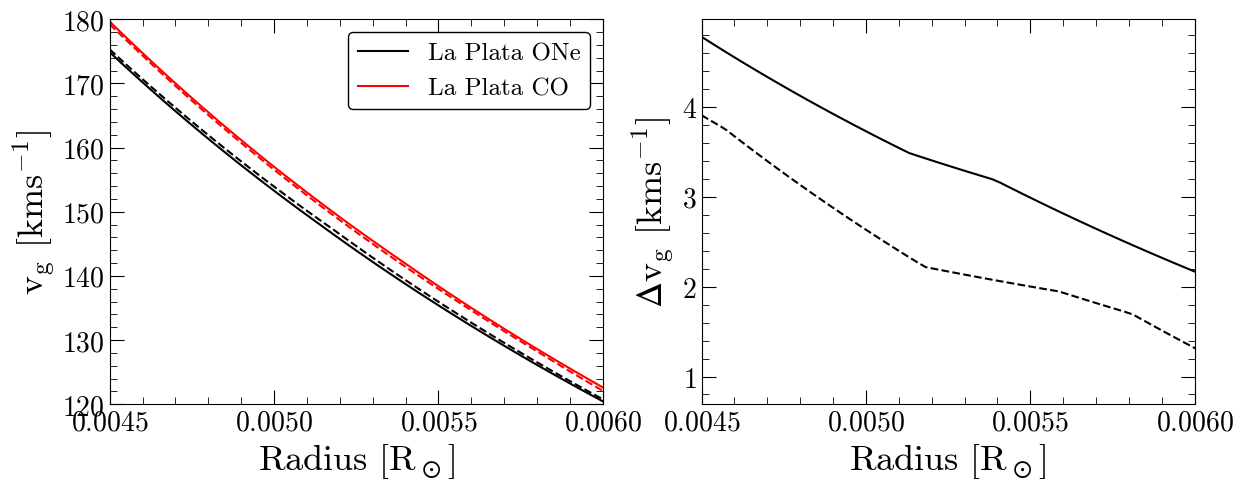

In [135]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 5))

# plot each of the four models
ax1.plot(rad_array, vg_array_one_hrich, c = 'k', label='La Plata ONe')
ax1.plot(rad_array, vg_array_one_hdef, c = 'k', ls = '--')
ax1.plot(rad_array, vg_array_co_hrich, c = 'r', label = 'La Plata CO')
ax1.plot(rad_array, vg_array_co_hdef, c = 'r', ls = '--')
# change the limits of the plot 
ax1.set_xlim(0.0045, 0.006)
ax1.set_ylim(120, 180)
# axis labels
ax1.set_xlabel(r'Radius [$R_\odot$]')
ax1.set_ylabel(r'$v_g$ [$kms^{-1}$]')
ax1.legend()

# plot the difference between the core composition models
ax2.plot(rad_array, vg_array_co_hrich - vg_array_one_hrich, c = 'k')
ax2.plot(rad_array, vg_array_co_hdef - vg_array_one_hdef, c = 'k', ls = '--')
# change the limits of the plot
ax2.set_xlim(0.0045, 0.006)
#axis labels
ax2.set_xlabel(r'Radius [$R_\odot$]')
ax2.set_ylabel(r'$\Delta v_g$ [$kms^{-1}$]')

## Sensitivity Testing

In [136]:
from Payne import utils as payne_utils
from astropy.table import Table
import corv
from tqdm import tqdm

base_wavl, model_spec, model_spec_low_logg, table = corv.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

test = Table.read('../data/raw/spect.SDSS J075523.89+194459.9.sdss.txt', format='ascii')
wavl = test['wavelength'].data

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/models/warwick_da


In [137]:
def doppler_shift(wavelength, flux, radial_velocity):
    # Speed of light in km/s
    c = 299792.458
    # Calculate the Doppler shift factor
    doppler_factor = np.sqrt((1 + radial_velocity / c) / (1 - radial_velocity / c))
    # Apply the Doppler shift to the wavelength
    shifted_wavelength = wavelength * doppler_factor
    return shifted_wavelength, flux

def simulate_spec(wl, params, distance, rv, snr, R = 3000):
    highres_flux = build_spec(params, distance)
    highres_flux = np.interp(wl, base_wavl, highres_flux)
    # smooth down to the correct resolution
    smoothed_flux = payne_utils.smoothing.smoothspec(wl, highres_flux, resolution=R, smoothtype="R")
    smoothed_flux[smoothed_flux < 0] = 0
    # calculate and add noise into the measurement
    noise = smoothed_flux / snr
    smoothed_flux += np.random.normal(loc=0, scale = noise)
    # add a doppler shift 
    wl, flux = doppler_shift(wl, smoothed_flux, rv)
    return wl, flux, 1/(noise**2)

Text(0, 0.5, 'Flux $[erg/cm^{2}/s/\\AA]$')

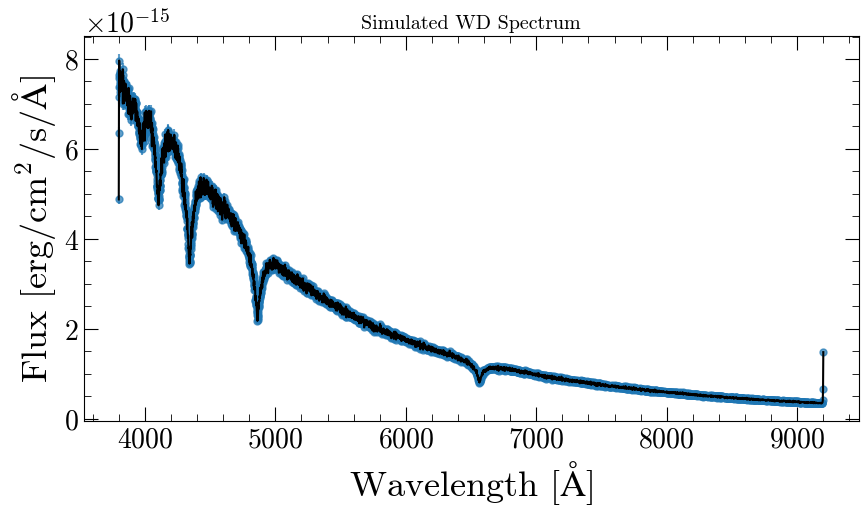

In [138]:
test_params = (29598.856100405897, 0.0058)
distance, rv, snr = 53.9, 17, 50
wl, flux, ivar = simulate_spec(wavl, test_params, distance, rv, snr)

plt.figure(figsize=(10,5))
plt.title('Simulated WD Spectrum')
plt.errorbar(wl, flux, yerr=1/np.sqrt(ivar), fmt='o', alpha=0.7, zorder=0)
plt.plot(wl, flux, c = 'k')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux $[erg/cm^{2}/s/\AA]$')

(23.846542264501863, 11.521287655253392, 1.0430957597232728)

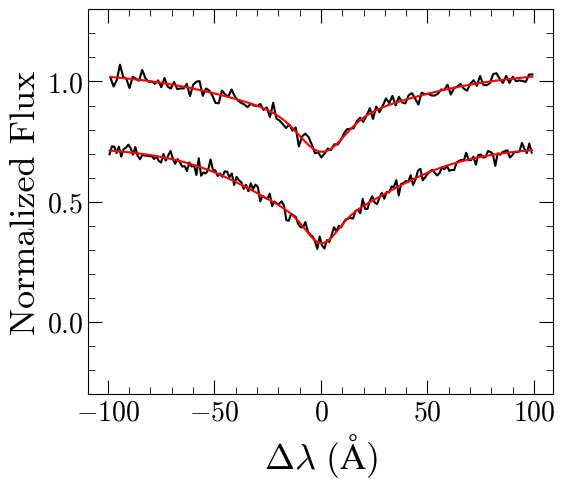

In [139]:
corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a','b'])
rv, e_rv, redchi, param_res = corv.fit.fit_corv(wl, flux, ivar, corvmodel)
corv.utils.lineplot(wl, flux, ivar, corvmodel, param_res.params, printparams = False, gap = 0.3, figsize = (6, 5))

rv, e_rv, redchi

In [140]:
# Tremblay+2019
dist_catalog = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/MNRAS/482/5222/tablea1.dat')
# Raddi+2022
wd_reference = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/658/A22/table5.dat.gz')

In [141]:
teff_counts, teff_bins = np.histogram(10**wd_reference['logTeff'], bins = 250)
teff_counts = teff_counts / sum(teff_counts)

dist_counts, dist_bins = np.histogram(100 / dist_catalog['plx'], bins = 250)
dist_counts = dist_counts / sum(dist_counts)

radius_counts, radius_bins = np.histogram(wd_reference['Radius'], bins = 100)
radius_counts = radius_counts / sum(radius_counts)

In [142]:
snr_grid = np.linspace(5, 75, 15)
n_sims = 20

snrs = []
teffs = []
dists = []
radii = []
rvs = []
measured_rvs = []
e_rvs = []

for ii, snr in enumerate(tqdm(snr_grid)):
    for jj in range(n_sims):
        teff = 12000
        dist = 200
        radius = np.random.uniform(low = 0.0045, high = 0.0060)
        rv = np.random.uniform(low = -50, high = 50)

        wl_fetched, fl, ivar = simulate_spec(wl, (teff, radius), dist, rv, snr, R = 3000)
        corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a','b'])
        measured_rv, e_rv, redchi, param_res = corv.fit.fit_corv(wl_fetched, fl, ivar, corvmodel)
        #corv.utils.lineplot(wl_fetched, fl, ivar, corvmodel, param_res.params, printparams = False, gap = 0.3, figsize = (6, 5))

        snrs.append(snr)
        teffs.append(teff)
        dists.append(dist)
        radii.append(radius)
        rvs.append(rv)
        measured_rvs.append(measured_rv)
        e_rvs.append(e_rv)

parameters = Table()
parameters['snr'] = snrs
parameters['teff'] = teffs
parameters['distance'] = dists
parameters['radius'] = radii
parameters['rv'] = rvs
parameters['measured_rv'] = measured_rvs
parameters['measured_e_rv'] = e_rvs


  7%|▋         | 1/15 [05:53<1:22:28, 353.49s/it]

In [ ]:
parameters

snr,teff,distance,radius,rv,measured_rv,measured_e_rv
float64,int64,int64,float64,float64,float64,float64
5.0,12000,200,0.004721360877182468,33.401611107092336,-43.22455917608548,43.01849176465843
5.0,12000,200,0.005057215117326834,-49.70982552474316,-24.363270484844428,39.30443001778475
5.0,12000,200,0.0052185718105578986,44.465102928543814,27.71119417227384,34.06721929053091
5.0,12000,200,0.005561280615461463,8.887955920350777,33.49356823026146,37.66875311996619
5.0,12000,200,0.005576527151681588,12.36721299677076,-50.60748215064832,34.40982166315514
5.0,12000,200,0.0057307360675899035,-26.770321358555638,-39.95932161031484,37.43690934719304
5.0,12000,200,0.005513926013997304,-17.78877142077755,-89.28369668958327,33.7260368184692
5.0,12000,200,0.005361026336414731,-0.7410544319869672,-6.278849595643044,29.079454024474934
5.0,12000,200,0.005536210788203413,36.215092130731605,48.97888377672746,49.28812299260727


Text(0, 0.5, '$\\Delta v_g$ [$kms^{-1}$]')

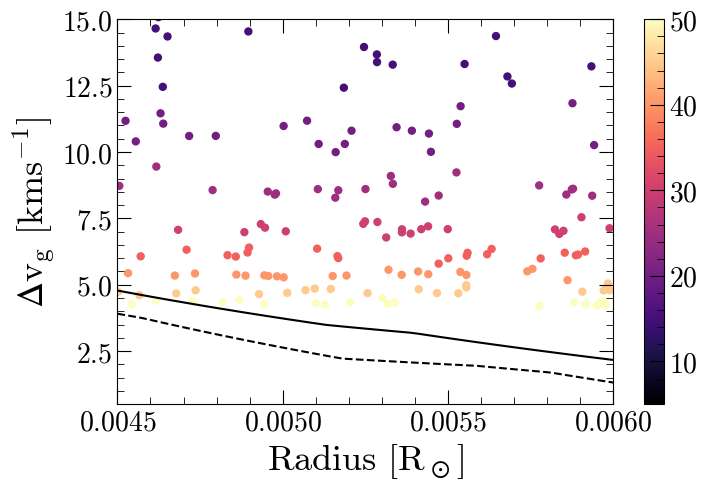

In [ ]:
plt.figure(figsize=(8, 5))
# plot the difference between the core composition models
plt.plot(rad_array, vg_array_co_hrich - vg_array_one_hrich, c = 'k')
plt.plot(rad_array, vg_array_co_hdef - vg_array_one_hdef, c = 'k', ls = '--')
#plt.scatter(parameters['radius'], parameters['measured_e_rv'], c=parameters['snr'], cmap='viridis')
plt.contourf(parameters['radius'], parameters['measured_e_rv'], parameters['snr'], 20, cmap='viridis')
plt.colorbar(label='SNR')
# change the limits of the plot
plt.xlim(0.0045, 0.006)
plt.ylim(0.5,15)
#axis labels
plt.xlabel(r'Radius [$R_\odot$]')
plt.ylabel(r'$\Delta v_g$ [$kms^{-1}$]')